# - Module 4 Final Project - 
# *Zillow Time Series Data Analysis*
<br/>
Student Name: Isabella Lindgren <br/>
Course: Part Time Data Science <br/>
Instructor: Eli <br/>
Presentation Date: Thursday, 12/5/2019


## Objective

For this project, our goal is to interpret and answer the following question: <br/>
> **What are the top 5 zip codes to invest in?**

I approached this question as a consultant for Citi Habitats Real Estate in New York City. There are over 100 zipcodes in the five boroughs of New York: the Bronx, Brooklyn, Manhattan, Kings County, and Richmond County (Staten Island). It is important to consider not only the profitability of the area, but the risk factors as well that may influence what makes a "good" investment property.  <br/>

 1.  Urbanization
 2.  Median House Price
 3.  Profitability/ROI
 4.  Demographics 

# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
plt.style.use('seaborn')
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools
from ast import literal_eval
import warnings
warnings.filterwarnings("ignore")

#!pip install pyshp
#import shapefile as shp
#!pip install pmdarima
import pmdarima as pm

# Define Useful Functions

In [2]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [3]:
def melt_data(df):
    # Use melt function to reshape with date as index, identifier variables set as id_vars
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
                     , var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.set_index('time',inplace=True)
    return melted
    # Return reshaped dataset with timeseries as index value, and mean house price
    return melted.groupby('time').aggregate({'value':'mean'})

In [4]:
def stationarityTest(df):
    """
    ts is the time series with time as index and target variable
    wd is the window for the rolling statistics test
    zipcode is the zipcode under analysis
    """
    
    rolmean = df.rolling(window = 12, center = False).mean()
    rolstd = df.rolling(window = 12, center = False).std()
    #plot rolling mean and std against original time series
    fig = plt.figure(figsize = (14, 7))
    orig = plt.plot(df, color ='blue', label = 'Original')
    mean = plt.plot(rolmean, color ='red', label ='Rolling Mean')
    std = plt.plot(rolstd, color ='black', label ='Rolling Std')
    plt.legend(loc ='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Dickey Fuller test only accepts 1d series, therefore we pass the values column only
    dftest = adfuller(df['value'])
    dfoutput = pd.Series(dftest[0:4], index =['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of observation'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value(%s)'%key] = value
    return(dfoutput)

In [5]:
def check_seasonality(df, col):
    # Use Statsmodels seasonal_decompose function to split time series variation into trend, seasonal variation and white noise
    result = seasonal_decompose(df)
    # Plot Trend, Seasonal and Residual on 3 consecutive axes
    result.trend.plot(ax=axes[0][col])
    axes[0][col].set_ylabel('Trend')
    result.seasonal.plot(ax=axes[1][col])
    axes[1][col].set_ylabel('Seasonal')
    result.resid.plot(ax=axes[2][col])
    axes[2][col].set_ylabel('Residual')

In [6]:
def check_autocorrelation(df, lags, col):
    plot_acf(df.value, lags=lags, ax=ax[0][col])
    plot_pacf(df.value, lags=lags, ax=ax[1][col])

# Load the Data

In [7]:
df = pd.read_csv('zillow_data.csv')
df.head() # preview

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


We can see from the preview that the data is in a wide format. Each date is a column. This will need to be reformatted in order to perform time series analysis. We can also see that the dates are in YYYY-MM format.

**Variable Descriptions** <br/>
 - RegionID: Zipcode
 - RegionName: Number assigned by Zillow
 - City: City where zip code is located
 - State: State where zip code is located
 - Metro: General Metropolitan Area
 - CountyName: Name of the county in which the zip code is located
 - SizeRank: ranks the zip code by degree of urbanization. Higher rank is more urbanized.
 - The values in the columns of the dates represent the median house cost of that particular zipcode in USD

# Data Preprocessing

It is important to always ensure that the dataset is clean and as complete as possible in order to create a successful model. First, we will narrow down the dataset so it only includes the scope of the five boroughs of New York. Then, we will identify any missing data and adjust accordingly. 

In [8]:
# Let's preview the info of the original dataset
# We can see that there are 14723 zipcodes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [9]:
# create a query that extracts all data where State is NY, City is New York, and Metro is New York
df.query('State =="NY" and City =="New York" and Metro == "New York"', inplace = True)
df.head(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
13,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
20,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300
21,61703,10128,New York,NY,New York,New York,22,3676700.0,3704200.0,3729600.0,...,7410100,7422400,7417600,7427300,7371400,7342700,7353300,7350300,7363000,7386600
35,61802,10462,New York,NY,New York,Bronx,36,154300.0,154300.0,154400.0,...,432800,436100,439900,443500,444100,443900,446000,446400,447200,450200
36,61796,10456,New York,NY,New York,Bronx,37,NaN,NaN,NaN,...,357900,357100,356500,357200,362000,368500,374100,379800,388100,394400
46,61803,10463,New York,NY,New York,Bronx,47,180100.0,181000.0,181900.0,...,680800,684500,692000,700900,710200,726900,744500,757000,769400,778700
47,62040,11230,New York,NY,New York,Kings,48,230100.0,230800.0,231500.0,...,1079200,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 6 to 11037
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 243.1+ KB


We can see that there are 114 zipcodes in our study area. Now that we have narrowed the scope of our data set, let's check if there are any missing values in our remaining data. 

In [11]:
# Let's rename this df to NY_df
NY_df = df
NY_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
13,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
20,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300


In [12]:
# Create a new column with number of missing values for each zipcode
cols = list(NY_df.columns[7:])
NY_df['NumValuesMissing'] = NY_df[cols].isna().sum(axis=1)

In [13]:
NY_df['NumValuesMissing'].value_counts()

0      104
93       6
105      1
87       1
213      1
189      1
Name: NumValuesMissing, dtype: int64

We can see that the majority of zipcodes (104) are not missing any data. 10 zipcodes are missing many (87-213) values. Since these observations are monthly, 12 observations are 1 years worth of data. Since the 10 zipcodes are missing more than a years' worth of data, we will drop them from the data frame.

In [14]:
# Create dataframe with all the zipcodes missing values
missingdata = NY_df[NY_df['NumValuesMissing']>12].sort_values(['NumValuesMissing'], ascending=False)

# Drop missing values with more than 1 year of observations missing
NY_df.drop(index=missingdata.index, inplace=True)

In [15]:
# Double check that there are no more zipcodes that are missing values
NY_df[NY_df['NumValuesMissing']>0]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,NumValuesMissing


Great! We can see that there are no more zipcodes with missing data. Next, we will transform the dates to datetime format for analysis.

In [16]:
# Let's drop the 'NumValuesMissing' column since it is no longer needed
NY_df = NY_df.drop(['NumValuesMissing'], axis=1)

# Now let's convert columns with dates to datetime format
pd.to_datetime(NY_df.columns[7:], format='%Y-%m')

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

# Zipcode Selection

My strategy is to determine which zipcodes are highly ranked in **Urbanization**, have the greatest mean house price growth historically, and present the lowest risk.

First, Let's determine which zipcodes are ranked in the top 25% of urbanized areas according to SizeRank.

In [17]:
#Get zipcodes with a sizerank in the top 25% (highly urbanized zipcodes).
print(NY_df.SizeRank.describe(),'\n')

#Calculate the 25% cutoff value.
sr_25 = NY_df.SizeRank.quantile(q=0.25)
print(f'Size Rank 25% cutoff value: {sr_25}')

#Get data frame with selected zipcodes. Keep values and zipcodes only.
zc_top25 = NY_df[NY_df['SizeRank']<sr_25].drop(['RegionID','City',
                                                       'State','Metro','CountyName',
                                                       'SizeRank'],axis=1)
print(f'Amount of zipcodes: {len(zc_top25)}')
print("Top Urbanized Zipcodes: ", zc_top25['RegionName'].unique())

count      104.000000
mean      2961.884615
std       2886.991024
min          7.000000
25%        298.250000
50%       2012.500000
75%       5170.250000
max      11038.000000
Name: SizeRank, dtype: float64 

Size Rank 25% cutoff value: 298.25
Amount of zipcodes: 26
Top Urbanized Zipcodes:  [10467 11226 11375 11235 10128 10462 10463 11230 11209 11212 11214 11221
 11229 11377 11234 11355 10314 11215 11211 11385 11373 11233 11236 11372
 11218 11223]


Now that we have the top urbanized zip codes, let's look at the **median house price** in these zipcodes. The zip code's average house price should be between 1.5 decile below and 1.5 decile above the zip code's 1 year median value.

In [18]:
zc_top25['yr_avg']=zc_top25.iloc[:,-12:].mean(skipna=True, axis=1)

#Get zipcodes with an average value 1.5 decile above the median and 1.5 deciles below.
print(zc_top25['yr_avg'].describe(),'\n')

#Calculate the 65% cutoff value (1 decile above).
q_65 = zc_top25['yr_avg'].quantile(q=0.65)
print(f'Average Value 65% cutoff value: {round(q_65,2)}')

#Calculate the 35% cutoff value (1.5 deciles below).
q_35 = zc_top25['yr_avg'].quantile(q=0.35)
print(f'Average Value 35% cutoff value: {round(q_35,2)}')

#Get data frame with selected zipcodes.
zc_pref = zc_top25[(zc_top25['yr_avg']<q_65) & (zc_top25['yr_avg']>q_35)]
print(f'Amount of zipcodes: {len(zc_pref)}')

print("Top preferred Zipcodes: ", zc_pref['RegionName'].unique())

count    2.600000e+01
mean     1.107354e+06
std      1.333859e+06
min      4.033083e+05
25%      6.542979e+05
50%      8.106083e+05
75%      1.007850e+06
max      7.377192e+06
Name: yr_avg, dtype: float64 

Average Value 65% cutoff value: 901597.92
Average Value 35% cutoff value: 743947.92
Amount of zipcodes: 8
Top preferred Zipcodes:  [11226 11235 11214 11377 11355 11373 11233 11372]


Last, we'll look at the **return on investment (ROI)** over time. We are using a risk averse investment strategy where zip codes will be selected according to a coefficient of variation below the 60 percentile.

In [19]:
zc_pref['ROI']= (zc_pref['2018-04']/zc_pref['1996-04'])-1

#Calculate standard deviation of monthly values
zc_pref['std']=zc_pref.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
zc_pref['mean']=zc_pref.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
zc_pref['CV']=zc_pref['std']/zc_pref['mean']

#Show calculated values
zc_pref[['RegionName','std','mean','ROI','CV']].head()

#Descriptive statistics of coefficients of variance.
print(zc_pref.CV.describe())
#Define upper limit of CV according to risk profile.
upper_cv = zc_pref.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')
#Get the 5 zipcodes with highest ROIs within the risk profile.
zc_best5 = zc_pref[zc_pref['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:5]
print('\n Best 5 Zipcodes:')
zc_best5[['RegionName','ROI','CV']]

count    8.000000
mean     0.404202
std      0.051916
min      0.348941
25%      0.377986
50%      0.383406
75%      0.415742
max      0.510009
Name: CV, dtype: float64

CV upper limit: 0.39044914148935705

 Best 5 Zipcodes:


,RegionName,ROI,CV
228,11372,3.531020,0.379479
140,11373,3.429875,0.379764
58,11214,3.419372,0.387049
13,11235,3.284514,0.348941
85,11377,3.259777,0.373506


### 'Best' Zipcodes
Zipcode: 11372 <br/>
Location: Jackson Heights, Queens
<br/><br/>
Zipcode: 11373 <br/>
Location: Elmhurst, Queens
<br/><br/>
Zipcode: 11214 <br/>
Location: Bath Beach/Bensonhurst, Brooklyn
<br/><br/>
Zipcode: 11235 <br/>
Location: Brighton Beach/Manhattan Beach/Sheepshead Bay, Brooklyn
<br/><br/>
Zipcode: 11377 <br/>
Location: Woodside, Queens

In [20]:
zc_best5.head(5)

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-12,2018-01,2018-02,2018-03,2018-04,yr_avg,ROI,std,mean,CV
228,11372,190200.0,190800.0,191700.0,192600.0,193500.0,194300.0,195100.0,196100.0,197300.0,...,845900,841900,848800,860100,861800,845958.333333,3.531020,188423.540817,496531.698113,0.379479
140,11373,175400.0,175800.0,176400.0,177000.0,177600.0,178200.0,178800.0,179800.0,180900.0,...,766900,773700,776100,775900,777000,760033.333333,3.429875,173459.227313,456755.471698,0.379764
58,11214,191000.0,191200.0,191500.0,191900.0,192100.0,192400.0,192800.0,193200.0,193800.0,...,826300,827600,830500,837300,844100,817275.000000,3.419372,184170.459178,475832.452830,0.387049
13,11235,190500.0,191000.0,191500.0,192000.0,192500.0,193000.0,193600.0,194300.0,195300.0,...,799700,806600,810600,813400,816200,789966.666667,3.284514,166512.159532,477193.207547,0.348941
85,11377,179000.0,178900.0,179000.0,179000.0,179100.0,179200.0,179300.0,179700.0,180200.0,...,749900,750300,753000,758200,762500,745508.333333,3.259777,166911.849275,446878.113208,0.373506


# Exploratory Data Analysis and Visualization

### Percentage Growth

Prior to 2008, the US experienced a major housing bubble caused by inflows of money into housing markets, loose lending conditions, and government policy to promote home-ownership. In 2008, there was a financial crisis in the US and the housing bubble burst causing the largest price drop in homes in history and the worst depression since the Great Depression of the 1930's. The economy and housing market has been recovering since 2008, but the rate of growth is not nearly as great as in the 1990's to early 2000's. It is important to take into account significant historical context when considering our data.
<br/><br/>
Let's look at the percentage growth in mean house price in two time frames: 1998-2008 and 2008-2018. We can expect to see the growth rate in the first time frame to be larger than the second due to the history. 

In [21]:
# Create dataframe of mean house price in NY
avgpriceNY = NY_df.groupby(['State']).mean()
#Drop unnecessary data
avgpriceNY.drop(['RegionID', 'RegionName', 'SizeRank'], axis=1, inplace=True)
avgpriceNY

# Compute % growth across the two specified periods
avgpriceNY['Growth 2008 to 2018'] = ((avgpriceNY['2018-04'] - avgpriceNY['2008-01'])/avgpriceNY['2008-01'])*100
avgpriceNY['Growth 1998 to 2008'] = ((avgpriceNY['2008-01'] - avgpriceNY['1998-01'])/avgpriceNY['1998-01'])*100

print("The growth in house prices from 2008-2019 in ", avgpriceNY['Growth 2008 to 2018'])
print("The growth in house prices from 1998-2008 in ", avgpriceNY['Growth 1998 to 2008'])

The growth in house prices from 2008-2019 in  State
NY    34.991451
Name: Growth 2008 to 2018, dtype: float64
The growth in house prices from 1998-2008 in  State
NY    157.84551
Name: Growth 1998 to 2008, dtype: float64


In [22]:
avgpriceNY

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Growth 2008 to 2018,Growth 1998 to 2008
State,,,,,,,,,,,,,,,,,,,,,
NY,214819.230769,215233.653846,215698.076923,216186.538462,216720.192308,217312.5,217988.461538,218839.423077,219902.884615,220883.653846,...,774016.346154,778725.961538,781374.038462,783982.692308,787730.769231,791819.230769,798902.884615,806192.307692,34.991451,157.84551


We can see that the percentage in house price growth is much lower from 2008-2018 compared to the percentage growth from 1998-2008. This is consistent with the historical data. This suggests that our model may be more accurate if we use the more recent data as it is extremely different from the pre-2008 data. 

# Reformat Data 

For time series analysis, we need to change the format from wide to long.

In [23]:
def melt_data(df):
    # Use melt function to reshape with date as index, identifier variables set as id_vars
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
                     , var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.set_index('time',inplace=True)
    return melted
    # Return reshaped dataset with timeseries as index value, and mean house price
    return melted.groupby('time').aggregate({'value':'mean'})

In [24]:
# create a list of the best zipcodes
zipcodes = list(zc_best5['RegionName'].unique())
zipcodes

[11372, 11373, 11214, 11235, 11377]

In [25]:
# Create new dataframe with long format data 
top5_df = pd.DataFrame()
for z in zipcodes:
    d = melt_data(NY_df[NY_df.RegionName==z])
    top5_df = pd.concat([d,top5_df])
top5_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,62088,11377,New York,NY,New York,Queens,86,179000.0
1996-05-01,62088,11377,New York,NY,New York,Queens,86,178900.0
1996-06-01,62088,11377,New York,NY,New York,Queens,86,179000.0
1996-07-01,62088,11377,New York,NY,New York,Queens,86,179000.0
1996-08-01,62088,11377,New York,NY,New York,Queens,86,179100.0


Let's plot the median housing prices for each zip code over time.

In [26]:
#top5_df['time']= top5_df.index
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x = 'time', y = 'value', hue="RegionName", data=top5_df)
ax.yaxis.set_ticks_position('both')

plt.legend(top5_df['RegionName'].unique(), ncol=1, bbox_to_anchor=(1.05, 1));

ValueError: Could not interpret input 'time'

<Figure size 720x432 with 0 Axes>

We can see that they all follow a similar trend with 11214 having the highest value and 11372 the lowest. Now let's plot with the std as well.

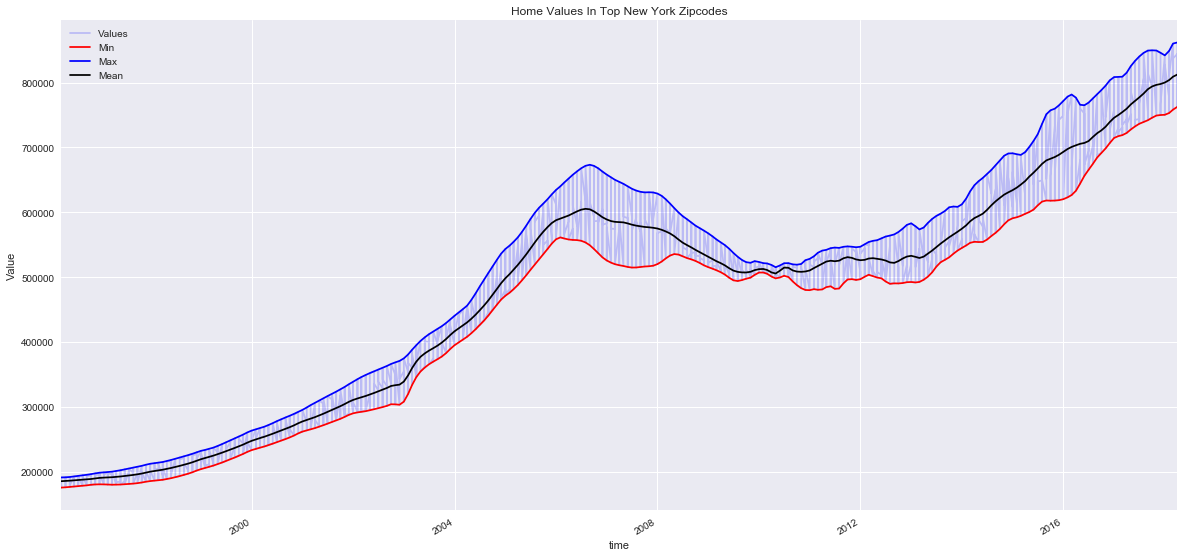

In [27]:
top5_df.value.plot(figsize=(20,10),label='Values',color='blue',alpha=0.2)
min_ = top5_df.groupby('time').aggregate({'value':'min'})
max_ = top5_df.groupby('time').aggregate({'value':'max'})
mean_ = top5_df.groupby('time').aggregate({'value':'mean'})
plt.plot(min_, color= 'red',label='Min')
plt.plot(max_, color='blue',label = 'Max')
plt.plot(mean_, color= 'black',label= 'Mean')
plt.legend()
plt.title('Home Values In Top New York Zipcodes')
plt.ylabel('Value')
plt.show()

We can see that there is a low std and an overall positive trend. Now let's plot each zip code individually so that we can see each zip code more clearly.

Text(0.5, 0.98, 'Top Zipcodes')

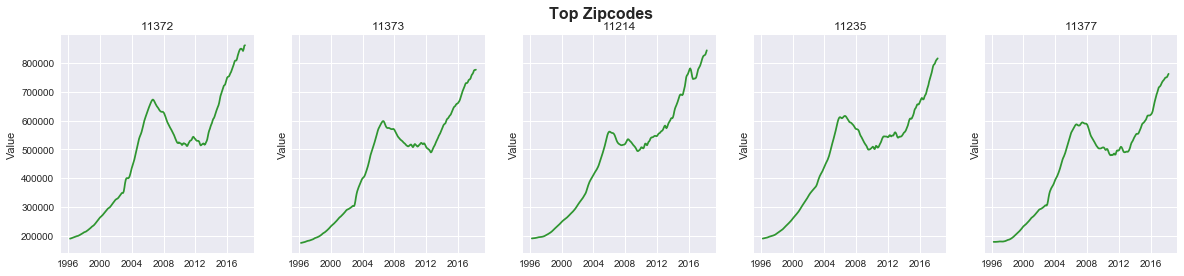

In [28]:
fig, axs = plt.subplots(1,5,figsize=(20,4),sharey=True)
for ax, column, index in zip(axs,zipcodes, range(0,5)):
    ax.plot(top5_df[top5_df.RegionName ==column].value, color='green',alpha=0.8)
    ax.set_title(column)
    ax.set_ylabel('Value')
fig.suptitle('Top Zipcodes', fontsize=16, fontweight='bold')

Next, we will slice our dataframe so it only include data from 2008 onwards since data from before the financial crisis will not be helpful in forcasting models.

In [29]:
# Slice the timeseries to contain data after year 2008. 

top5_post2008 = top5_df['2008':]
top5_post2008.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
2008-01-01,62088,11377,New York,NY,New York,Queens,86,586600.0
2008-02-01,62088,11377,New York,NY,New York,Queens,86,581400.0
2008-03-01,62088,11377,New York,NY,New York,Queens,86,574900.0
2008-04-01,62088,11377,New York,NY,New York,Queens,86,567300.0
2008-05-01,62088,11377,New York,NY,New York,Queens,86,559200.0


In [30]:
# Remove irrelevant data
top5_post2008.drop(columns=['RegionID', 'City', 'State', 'Metro', 'SizeRank', 'CountyName'], inplace=True)

In [31]:
top5_post2008.head()

,RegionName,value
time,,
2008-01-01,11377,586600.0
2008-02-01,11377,581400.0
2008-03-01,11377,574900.0
2008-04-01,11377,567300.0
2008-05-01,11377,559200.0


Now we will create a separate dataframe for each of the top 5 zipcodes we selected from our real estate criteria. 

In [32]:
JacksonHeights = top5_post2008.loc[top5_post2008['RegionName']==11372]
Elmhurst = top5_post2008.loc[top5_post2008['RegionName']==11373]
BathBeach = top5_post2008.loc[top5_post2008['RegionName']==11214]
BrightonBeach = top5_post2008.loc[top5_post2008['RegionName']==11235]
Woodside = top5_post2008.loc[top5_post2008['RegionName']==11377]

Let's see a preview of one of our new time series dataframes to make sure the format is optimal for analysis.

In [33]:
JacksonHeights.head()

,RegionName,value
time,,
2008-01-01,11372,628800.0
2008-02-01,11372,625200.0
2008-03-01,11372,619900.0
2008-04-01,11372,613300.0
2008-05-01,11372,606400.0


## Check for Stationarity

When working with time series data, most models work on the assumption that the data is **stationary**. This means it's statistical properties (i.e. mean, variance, autocorrelation) remain constant over time. Next we will check to see if our data is stationary or if it shows any trends. 
<br/><br/>
We can do this by plotting the rolling mean and standard deviation against the original data to visually see if there are any trends and by using the Dickey-Fuller Test.

The null hypothesis for Dickey Fuller is that the data is not stationary.

In [34]:
def stationarityTest(df):
    """
    ts is the time series with time as index and target variable
    wd is the window for the rolling statistics test
    zipcode is the zipcode under analysis
    """
    
    rolmean = df.rolling(window = 12, center = False).mean()
    rolstd = df.rolling(window = 12, center = False).std()
    #plot rolling mean and std against original time series
    fig = plt.figure(figsize = (14, 7))
    orig = plt.plot(df, color ='blue', label = 'Original')
    mean = plt.plot(rolmean, color ='red', label ='Rolling Mean')
    std = plt.plot(rolstd, color ='black', label ='Rolling Std')
    plt.legend(loc ='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Dickey Fuller test only accepts 1d series, therefore we pass the values column only
    dftest = adfuller(df['value'])
    dfoutput = pd.Series(dftest[0:4], index =['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of observation'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value(%s)'%key] = value
    return(dfoutput)

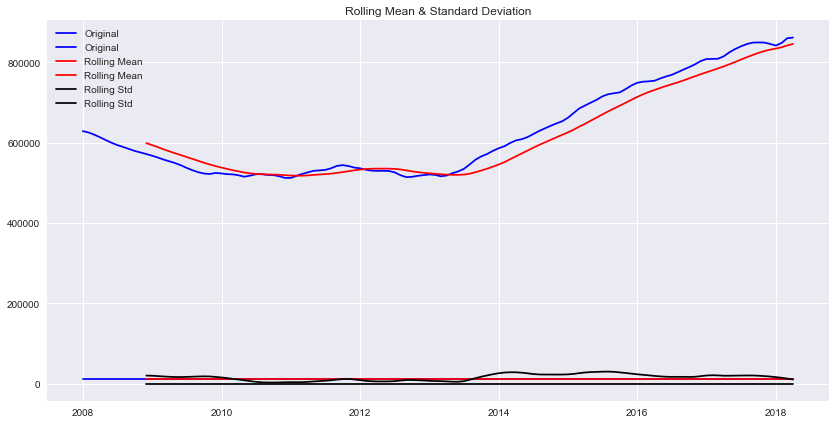

Test Statistic            -1.054656
p-value                    0.732812
#Lags Used                 8.000000
Number of observation    115.000000
Critical Value(1%)        -3.488535
Critical Value(5%)        -2.887020
Critical Value(10%)       -2.580360
dtype: float64

In [35]:
stationarityTest(JacksonHeights)
# positive trend and p-value of 0.73

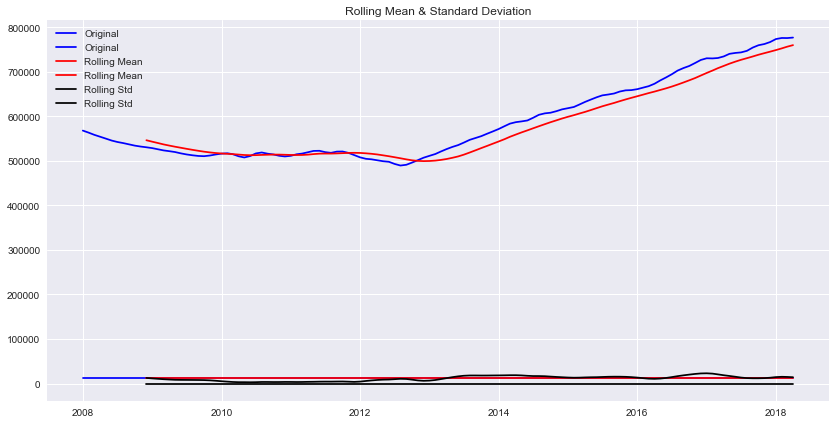

Test Statistic            -0.448965
p-value                    0.901597
#Lags Used                13.000000
Number of observation    110.000000
Critical Value(1%)        -3.491245
Critical Value(5%)        -2.888195
Critical Value(10%)       -2.580988
dtype: float64

In [36]:
stationarityTest(Elmhurst)
# positive trend and p-value of 0.9

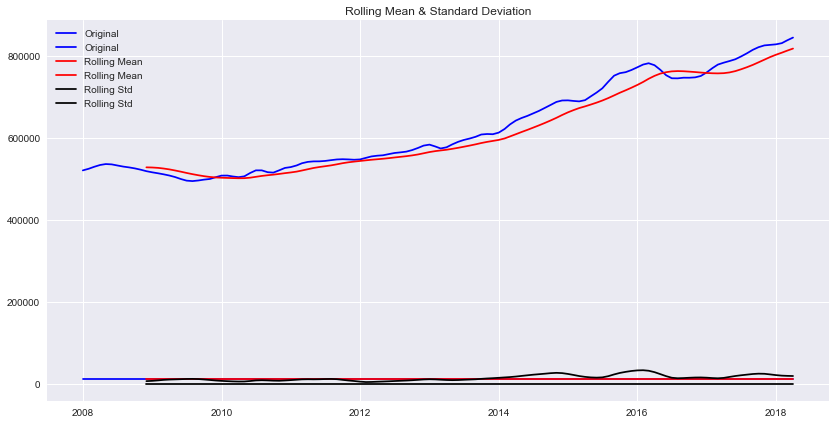

Test Statistic             1.495333
p-value                    0.997507
#Lags Used                 9.000000
Number of observation    114.000000
Critical Value(1%)        -3.489058
Critical Value(5%)        -2.887246
Critical Value(10%)       -2.580481
dtype: float64

In [37]:
stationarityTest(BathBeach)
# positive trend and p-value of 0.99

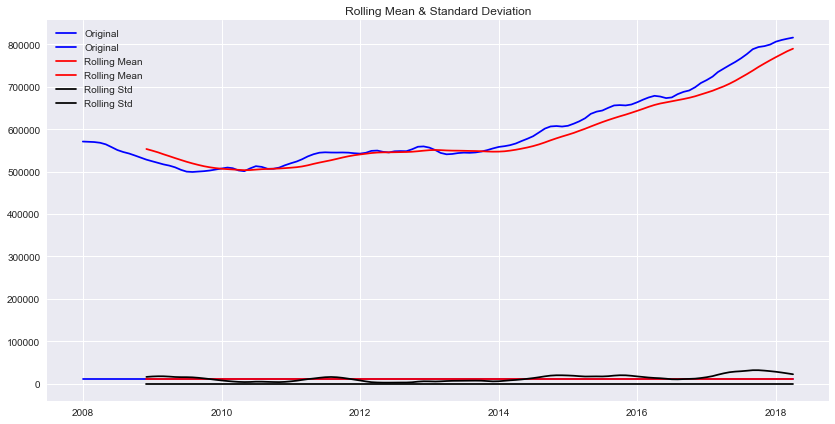

Test Statistic             0.839325
p-value                    0.992245
#Lags Used                 9.000000
Number of observation    114.000000
Critical Value(1%)        -3.489058
Critical Value(5%)        -2.887246
Critical Value(10%)       -2.580481
dtype: float64

In [38]:
stationarityTest(BrightonBeach)
# positive trend and p-value of 0.99

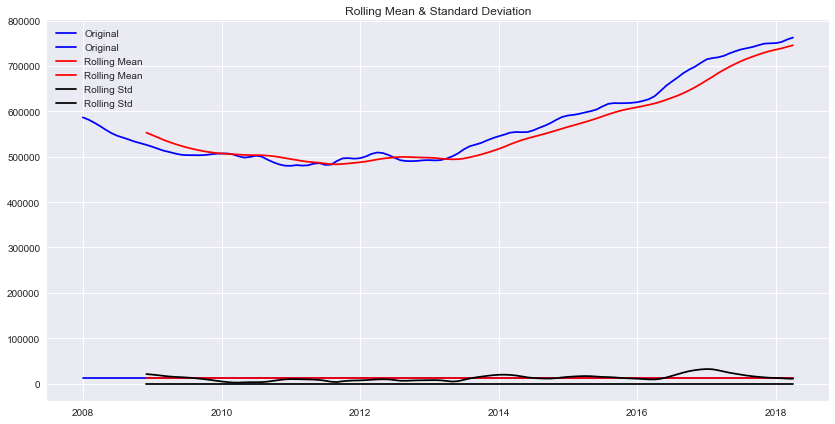

Test Statistic             0.411356
p-value                    0.981915
#Lags Used                13.000000
Number of observation    110.000000
Critical Value(1%)        -3.491245
Critical Value(5%)        -2.888195
Critical Value(10%)       -2.580988
dtype: float64

In [39]:
stationarityTest(Woodside)
# positive trend and p-value of 0.98

For all five of the zipcodes:
 - The rolling mean shows a trend
 - The Dickey-Fuller test cannot reject the null hypothesis of nonstationarity
<br/>
<br/>
We can assume from these results that the data is **NOT STATIONARY** so our model needs to correct the non-stationarity.

## Check for Seasonality

In [40]:
# Assess seasonality of data 
def check_seasonality(df, col):
    # Use Statsmodels seasonal_decompose function to split time series variation into trend, seasonal variation and white noise
    result = seasonal_decompose(df)
    # Plot Trend, Seasonal and Residual on 3 consecutive axes
    result.trend.plot(ax=axes[0][col])
    axes[0][col].set_ylabel('Trend')
    result.seasonal.plot(ax=axes[1][col])
    axes[1][col].set_ylabel('Seasonal')
    result.resid.plot(ax=axes[2][col])
    axes[2][col].set_ylabel('Residual')

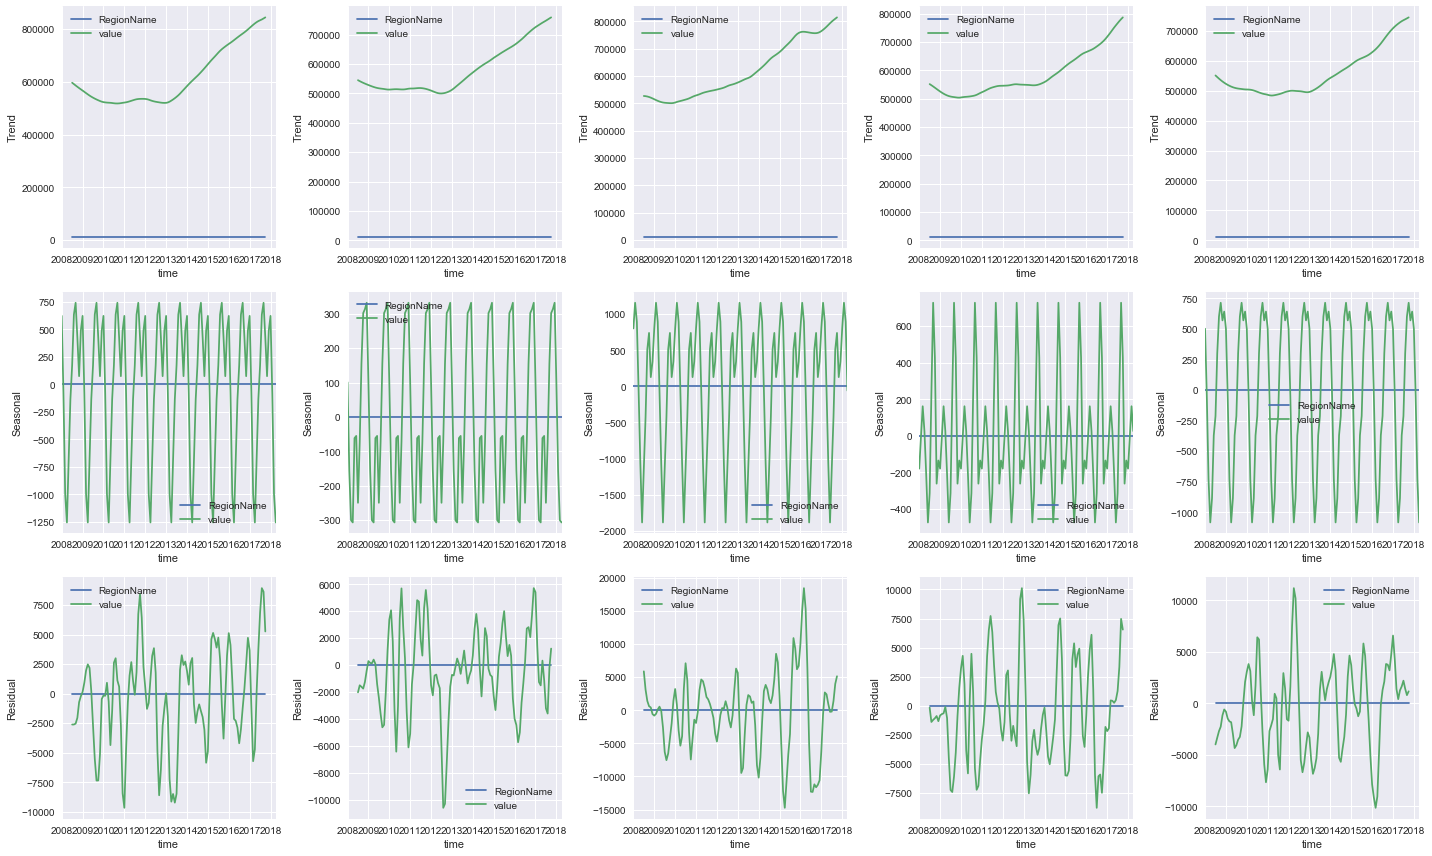

In [41]:
# Create 3X3 grid of plots, each column contains one zipcode, each row contains a trend, seasonal or white noise component
fig, axes = plt.subplots(3,5, figsize=(20,12))

# Apply check_seasonality() function to decompose the time series into a trend, seasonal and white noise component
check_seasonality(JacksonHeights,0)

check_seasonality(Elmhurst,1)

check_seasonality(BathBeach,2)

check_seasonality(BrightonBeach,3)

check_seasonality(Woodside,4)

fig.tight_layout()
plt.show()

We can see that there seems to be an annual seasonality in house prices, but it is very small. We may need to control for this in the selected model. 

# ARIMA Modeling

## ACF and PACF
<br/>
Plotting the AutoCorrelation Function (ACF) and Partial-AutoCorrelation Function (PACF) for time series data allows us to visualize and understand the impact of past data on today's values. This allows us to include lagged terms (dependent variables and error terms) in our model to improve performance and predictive power.

In [42]:
# Plot the autocorrelation and partial autocorrelation functions for a given dataset and number of lags
def check_autocorrelation(df, lags, col):
    plot_acf(df.value, lags=lags, ax=ax[0][col])
    plot_pacf(df.value, lags=lags, ax=ax[1][col])

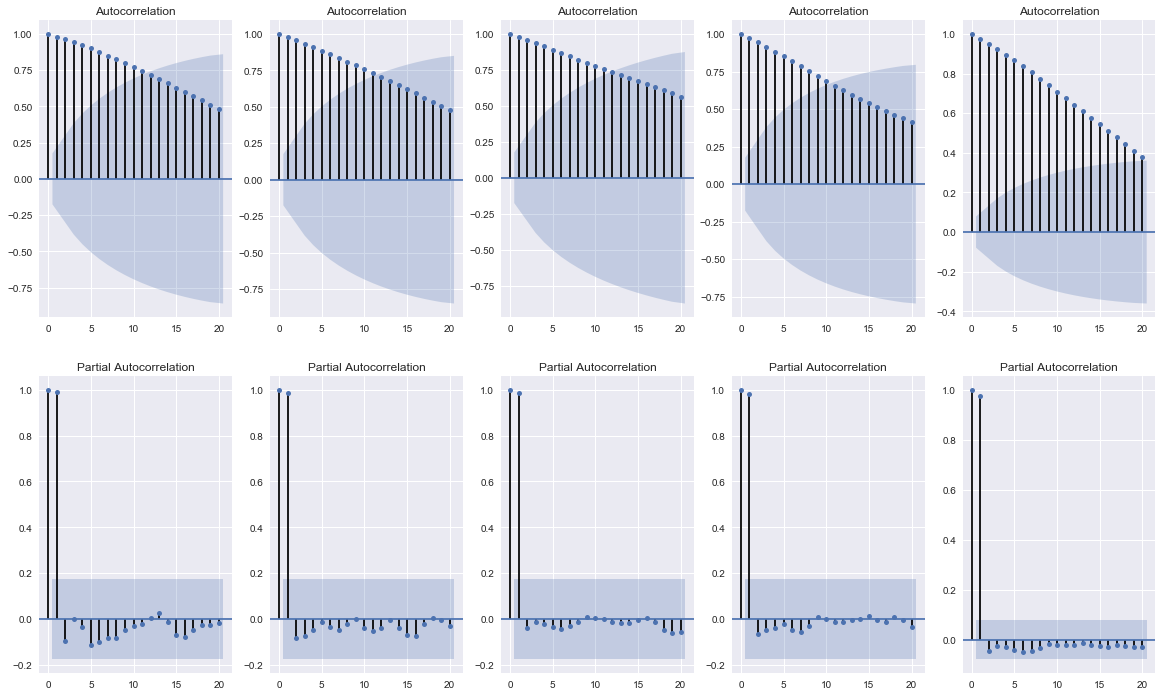

In [43]:
# Create a 2 X 5 figure to display the ACF and PACF
fig,ax = plt.subplots(2,5,figsize=(20,12))

# Run the check_autocorrelation() function, which plots the acf and pacf for a given dataset
check_autocorrelation(JacksonHeights, 20, 0)
check_autocorrelation(Elmhurst, 20, 1)
check_autocorrelation(BathBeach, 20, 2)
check_autocorrelation(BrightonBeach, 20, 3)
check_autocorrelation(top5_post2008, 20, 4)

As can be seen from the autocorrelation plots above, around historic house prices for about 11 periods (months) seem to be important in determinging the value of houses today. However, once the prior periods are controlled for, by the partial autocorrelation plot, this falls to 2 lagged period.

We would therefore expect 2 lagged dependent variables and/or 2 lagged residuals to be necessary in our model.
<br/><br/>
Now let's check to see if differencing reduces the trend and seasonality.

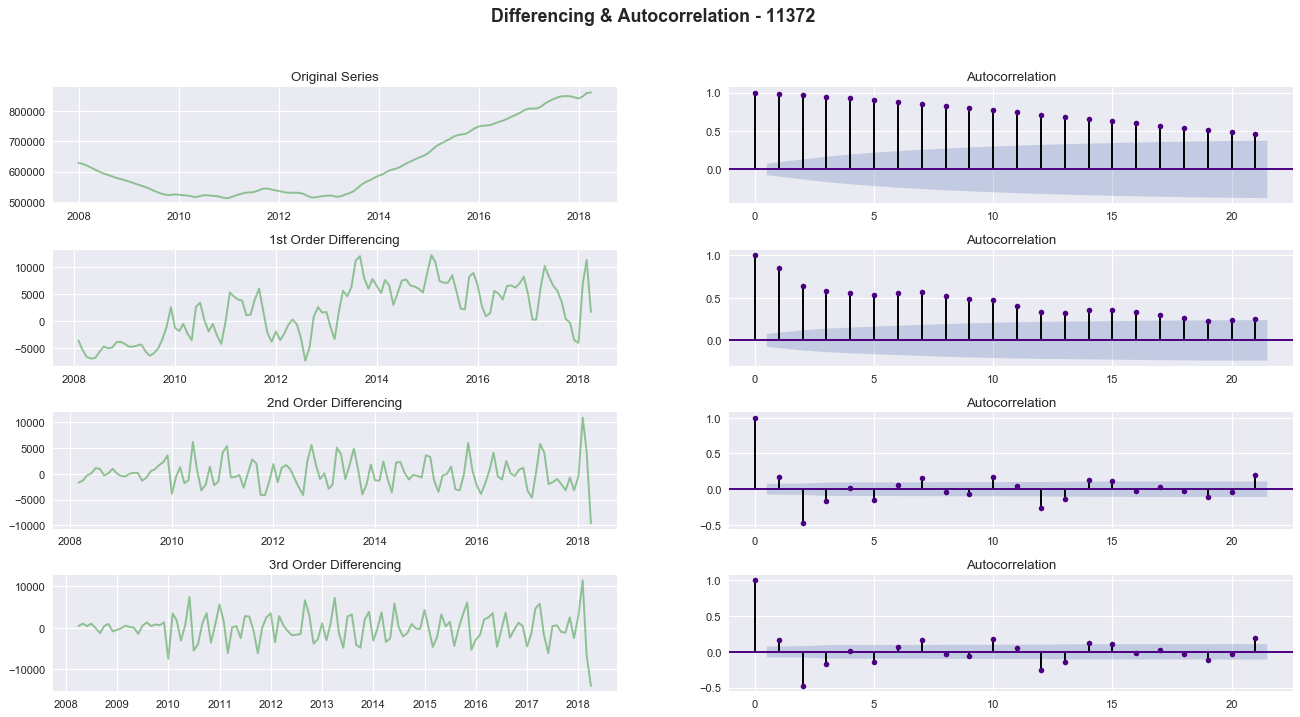

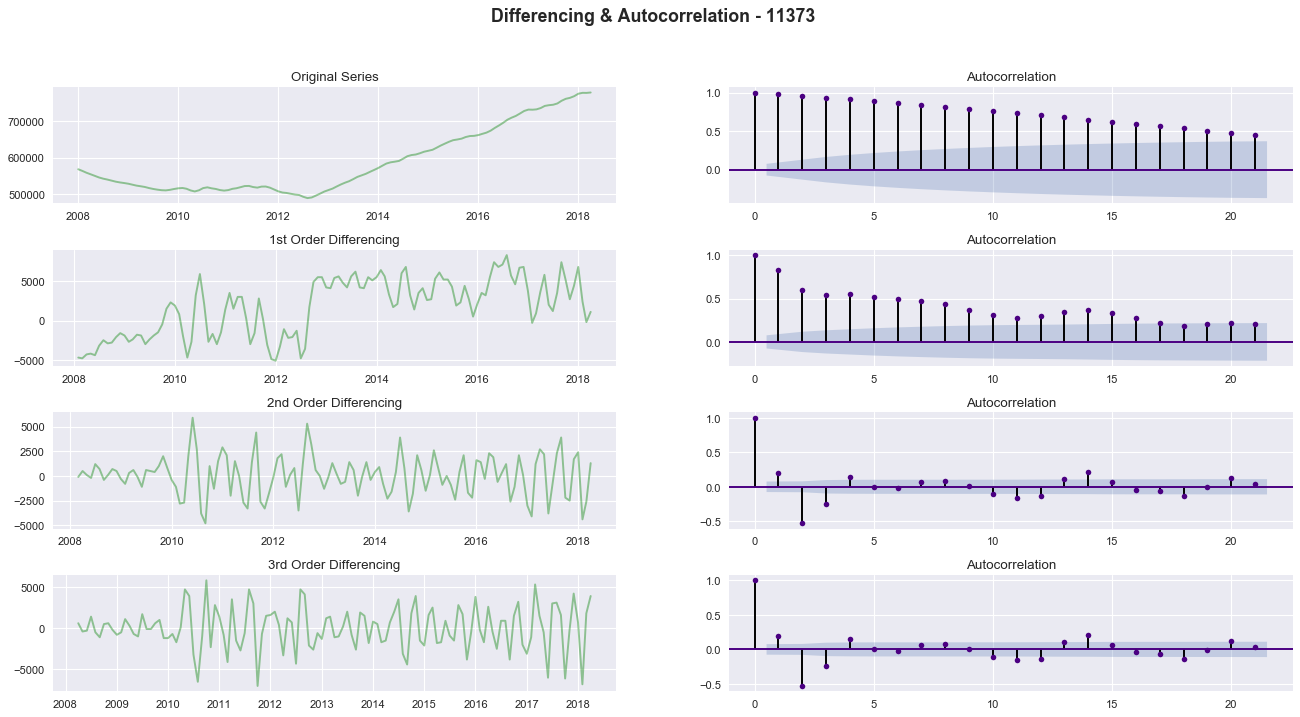

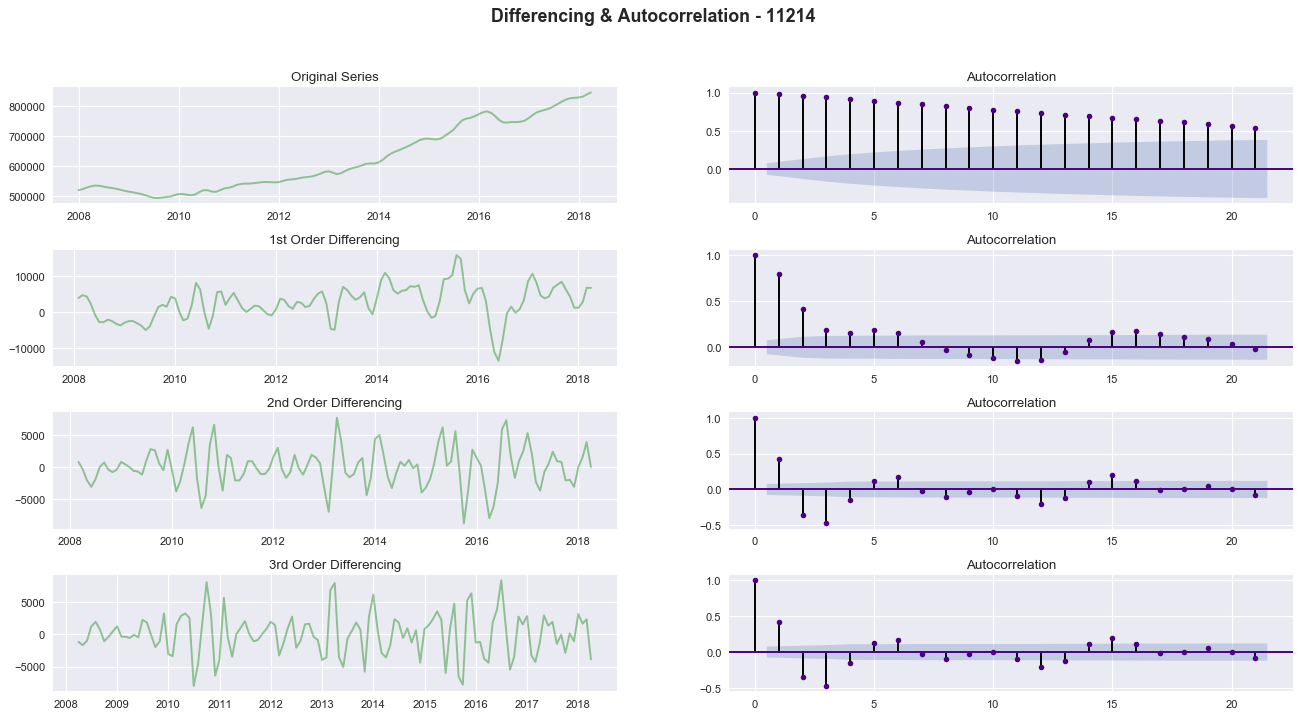

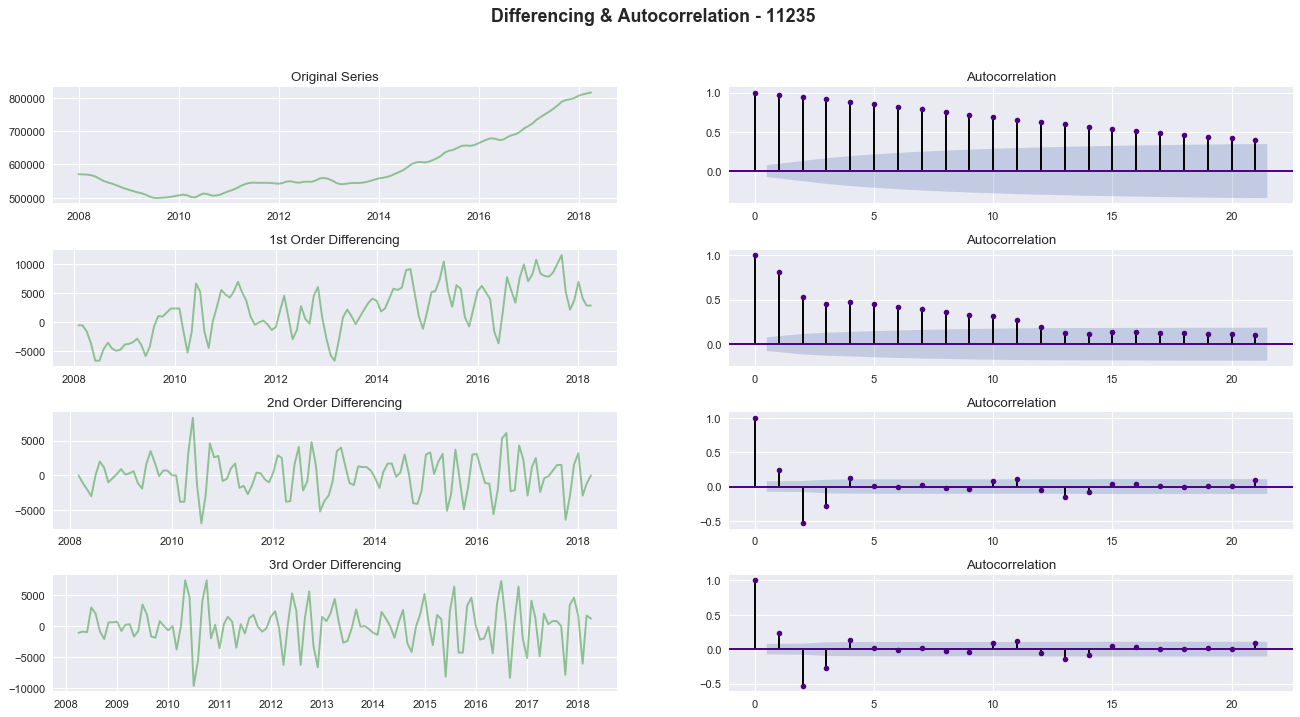

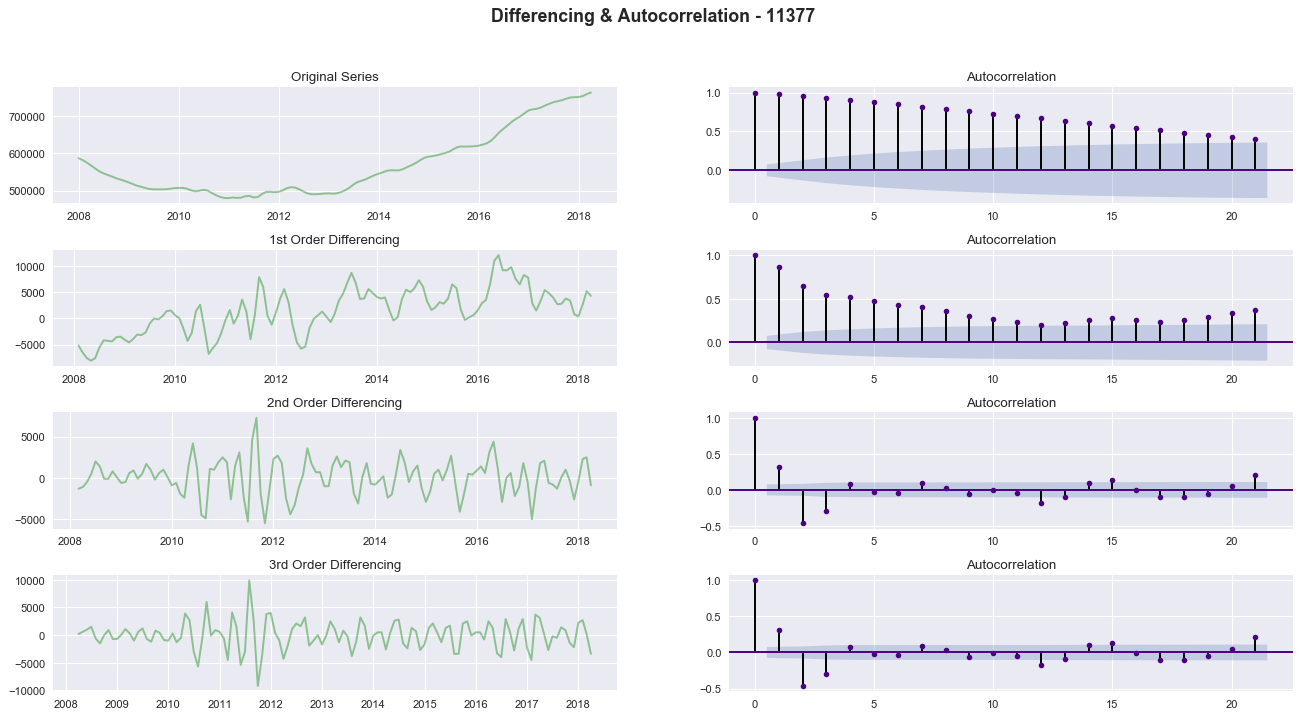

In [53]:
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':80})
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Import data
for z in zipcodes: 
    df_z = top5_post2008[top5_post2008.RegionName == z]
# Original Series
    fig, axes = plt.subplots(4, 2)
    axes[0, 0].plot(df_z.value,color='green',alpha=0.4); axes[0, 0].set_title('Original Series',fontsize=12)
    plot_acf(df_z.value, ax=axes[0, 1], color='indigo',alpha=0.4)

    # 1st Differencing
    axes[1, 0].plot(df_z.value.diff(), color='green',alpha=0.4); axes[1, 0].set_title('1st Order Differencing',fontsize=12)
    plot_acf(df_z.value.diff().dropna(), ax=axes[1, 1], color='indigo',alpha=0.4)

    # 2nd Differencing
    axes[2, 0].plot(df_z.value.diff().diff(), color='green',alpha=0.4); axes[2, 0].set_title('2nd Order Differencing',fontsize=12)
    plot_acf(df_z.value.diff().diff().dropna(), color='indigo',alpha=0.4, ax=axes[2, 1])
    
     # 3nd Differencing
    axes[3, 0].plot(df_z.value.diff().diff().diff(), color='green',alpha=0.4); axes[3, 0].set_title('3rd Order Differencing',fontsize=12)
    plot_acf(df_z.value.diff().diff().dropna(), ax=axes[3, 1],  color='indigo',alpha=0.4)

    fig.suptitle('Differencing & Autocorrelation - ' + str(z), fontsize=16, fontweight='bold')
    plt.subplots_adjust(hspace = 0.4 )
    plt.show()

We should account for 2 orders of differencing for all five zipcodes.

## ARIMA Modeling and Forecasting

ARIMA stands for AutoregRessive Integrated Moving Average. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.
<br/>
 - p = number of AR (Auto-Regressive) terms
 - d = number of differences
 - q = number of MA (Moving Average) terms

In [59]:
# Identify optimal order of SARIMAX function.  p, d, and q represent maximum values
def optimise_sarimax(df, p, d, q):
    
    # Create a list with all possible values for p, d and q up to specified maximum
    p = list(range(0,p))
    d = list(range(0,d))
    q = list(range(0,q))


    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency given annual cyclicality)
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    
    # Create dataframe that displays order v. AIC criterion.  Order with lowest AIC selected
    results = []

    for i in range(0, len(pdqs)):
        model = sm.tsa.statespace.SARIMAX(endog=df, order = pdq[i], seasonal_order = pdqs[i], enforce_stationarity = False, enforce_invertibility = False, freq='MS')
        result = model.fit(maxiter=200)
        results.append({'pdq': f"{pdq[i]}", 'pdqs': f"{pdqs[i]}", 'AIC':result.aic})
    
    results_df = pd.DataFrame(results)
    results_df.sort_values(by=['AIC'], ascending = True, inplace=True)
    
    return results_df

In [60]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
arima_results = []
for i in range(len(zipcodes)):
    series = top5_post2008.value
    ans=[]
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(series,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic, output.bic])

            except:
                continue
    arima_results.append(ans)

In [ ]:
# arima_results

In [ ]:
minAICs =[]
for i in range(len(arima_results)):
    ans_df = pd.DataFrame(arima_results[i], columns =['pdq', 'pdqs','aic','bic'])
    minAICs.append(ans_df.loc[ans_df['aic'].idxmin()])

In [ ]:
# plug the optimal parameter values into a new SARIMAX model.
outputs =[]
for i in range(len(minAICs)):
    series = top5_post2008.value
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(series,
                                    order=minAICs[i]['pdq'],
                                    seasonal_order= minAICs[i]['pdqs'],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    # Fit the model and print results
    output = ARIMA_MODEL.fit()
    
    #print(top5_post2008.RegionName)
    print('Non-seasonal parameters (p,d,q):', minAICs[i]['pdq'])
    print('Seasonal parameters and periodicity (P,D,Q,s):', minAICs[i]['pdqs'])
    print('AIC:', minAICs[i]['aic'])
    print('BIC:', minAICs[i]['bic'])
    print(output.summary().tables[1])
    output.plot_diagnostics(figsize=(15,18))
    plt.show()
    outputs.append(output)
    print('\n')

The QQ plots for this function show long tails suggesting that the data is not normally distributed or stationary. Let's try a different method using the auto_arima package in pmdarima which is more accurate and then use the results from the auto_arima for our forecasting.

# Modeling and Forecasting

This function calls for ARIMA modeling using pmdarima auto_arima in order to determine optimal p,d,q values and including seasonality. Then it splits the data for each zip code into a train and test set (80% train, 20% test) which we use to create our model. The function then compares the forecast to the actual historical data and then projects the following 4 years.

In [295]:
# Let's determine the test and training data lengths
# Confirm how many periods are covered by the dataset
n = len(JacksonHeights)
training_n = int(n*0.8)
print('Number of Obs Training Set: ', training_n)
print('Number of Obs Test Set: ', n - training_n)

124

Zip:  11372
ADF Statistic Residual: -3.225160
p-value: 0.018574


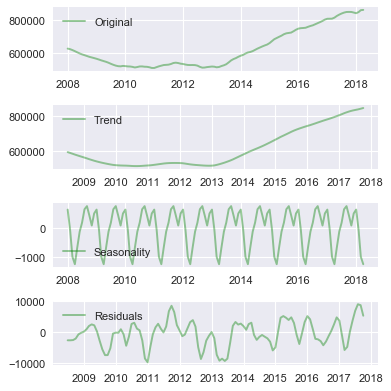

Fit ARIMA: order=(1, 2, 1); AIC=2262.167, BIC=2273.383, Fit time=0.227 seconds
Fit ARIMA: order=(0, 2, 0); AIC=2283.408, BIC=2289.016, Fit time=0.004 seconds
Fit ARIMA: order=(1, 2, 0); AIC=2281.656, BIC=2290.068, Fit time=0.076 seconds
Fit ARIMA: order=(0, 2, 1); AIC=2261.845, BIC=2270.257, Fit time=0.137 seconds
Fit ARIMA: order=(0, 2, 2); AIC=2245.901, BIC=2257.117, Fit time=0.185 seconds
Fit ARIMA: order=(1, 2, 3); AIC=2205.677, BIC=2222.501, Fit time=0.694 seconds
Fit ARIMA: order=(0, 2, 3); AIC=2209.451, BIC=2223.471, Fit time=0.328 seconds
Fit ARIMA: order=(2, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 2); AIC=2238.237, BIC=2252.257, Fit time=0.382 seconds
Fit ARIMA: order=(1, 2, 4); AIC=2207.340, BIC=2226.968, Fit time=0.661 seconds
Fit ARIMA: order=(2, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 3.210 seconds
11372
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   

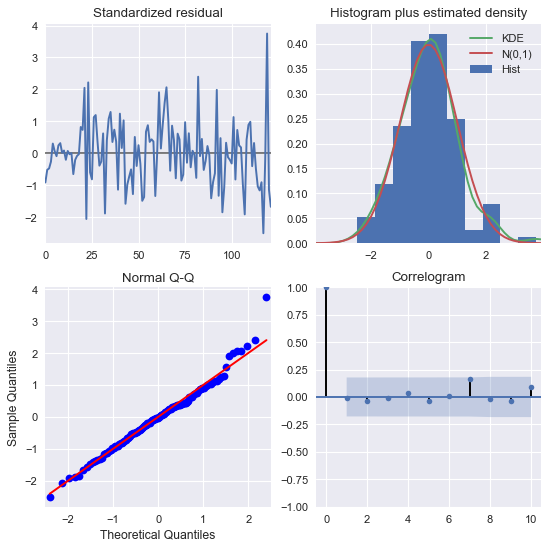

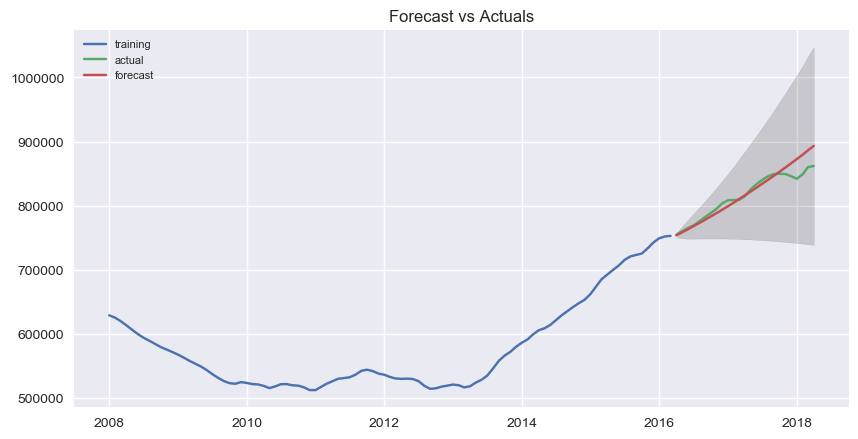

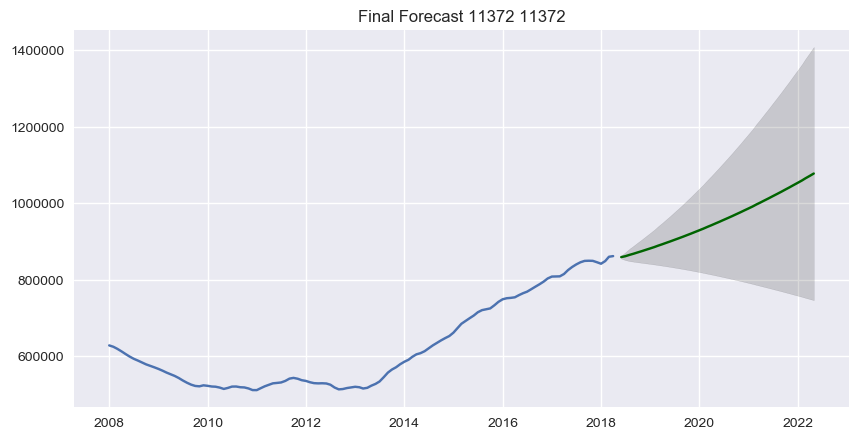

11372
Model Order:  (1, 2, 3)
Upside case 2022:  1407616.2930964562 ROI:  63.832791857216066
Base   case 2022:  1077262.0385635989 ROI:  25.382782371343588
Low    case 2022:  746907.7840307415 ROI:  -13.067227114528887
Zip:  11373
ADF Statistic Residual: -4.390671
p-value: 0.000308


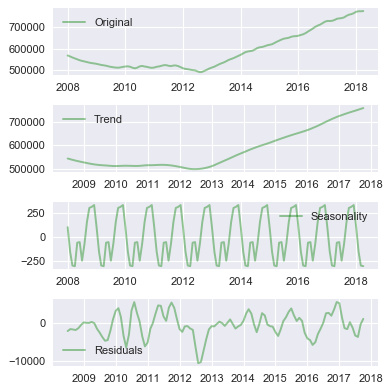

Fit ARIMA: order=(1, 2, 1); AIC=2185.289, BIC=2196.505, Fit time=0.234 seconds
Fit ARIMA: order=(0, 2, 0); AIC=2207.190, BIC=2212.798, Fit time=0.004 seconds
Fit ARIMA: order=(1, 2, 0); AIC=2204.516, BIC=2212.928, Fit time=0.052 seconds
Fit ARIMA: order=(0, 2, 1); AIC=2185.046, BIC=2193.458, Fit time=0.065 seconds
Fit ARIMA: order=(0, 2, 2); AIC=2170.512, BIC=2181.728, Fit time=0.157 seconds
Fit ARIMA: order=(1, 2, 3); AIC=2125.483, BIC=2142.307, Fit time=0.787 seconds
Fit ARIMA: order=(0, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 3); AIC=2126.877, BIC=2146.506, Fit time=0.924 seconds
Fit ARIMA: order=(1, 2, 2); AIC=2160.840, BIC=2174.860, Fit time=0.361 seconds
Fit ARIMA: order=(1, 2, 4); AIC=2127.095, BIC=2146.723, Fit time=1.595 seconds
Fit ARIMA: order=(2, 2, 4); AIC=2128.874, BIC=2151.306, Fit time=1.519 seconds
Total fit time: 5.716 seconds
11373
                             ARIMA Model Results                              
Dep. Variable:              

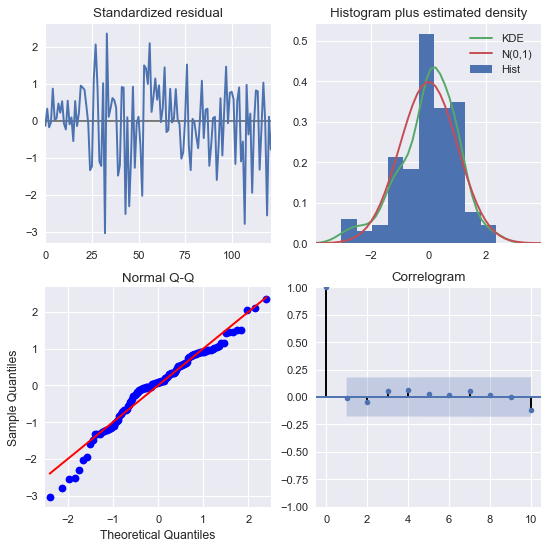

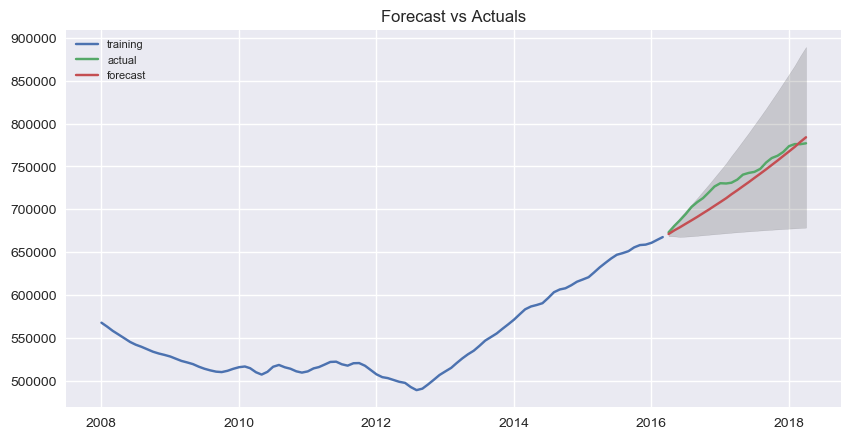

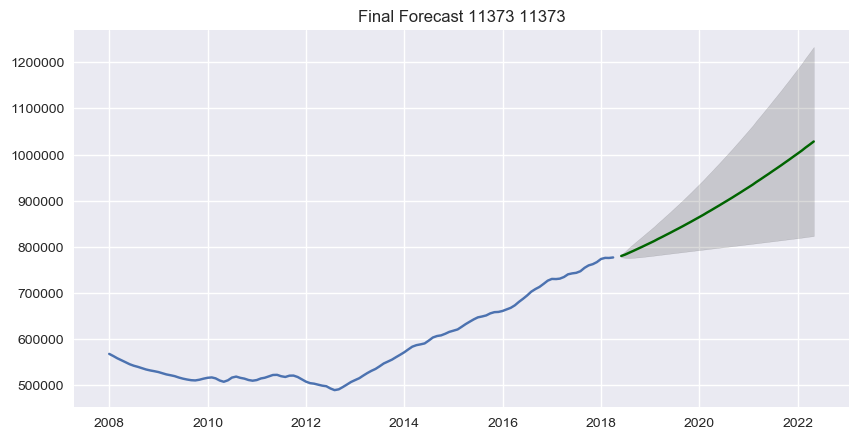

11373
Model Order:  (1, 2, 3)
Upside case 2022:  1233077.3658921039 ROI:  58.048170565965876
Base   case 2022:  1028244.2307446781 ROI:  31.793936097944158
Low    case 2022:  823411.0955972522 ROI:  5.539701629922448
Zip:  11214
ADF Statistic Residual: -5.623630
p-value: 0.000001


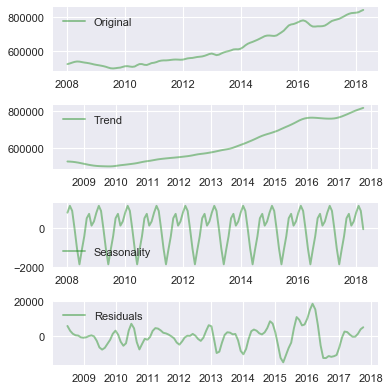

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=2428.956, BIC=2434.580, Fit time=0.001 seconds
Fit ARIMA: order=(1, 1, 0); AIC=2308.168, BIC=2316.605, Fit time=0.125 seconds
Fit ARIMA: order=(0, 1, 1); AIC=2307.785, BIC=2316.221, Fit time=0.146 seconds
Fit ARIMA: order=(0, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=2204.969, BIC=2219.029, Fit time=0.465 seconds
Fit ARIMA: order=(2, 1, 2); AIC=2202.297, BIC=2219.170, Fit time=0.755 seconds
Fit ARIMA: order=(2, 1, 1); AIC=2231.531, BIC=2245.592, Fit time=0.302 seconds
Fit ARIMA: order=(2, 1, 3); AIC=2203.584, BIC=2223.270, Fit time=0.527 seconds
Fit ARIMA: order=(3, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 2); AIC=2203.469, BIC=2223.154, Fit time=0.770 seconds
Total fit time: 3.558 seconds
11214
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observat

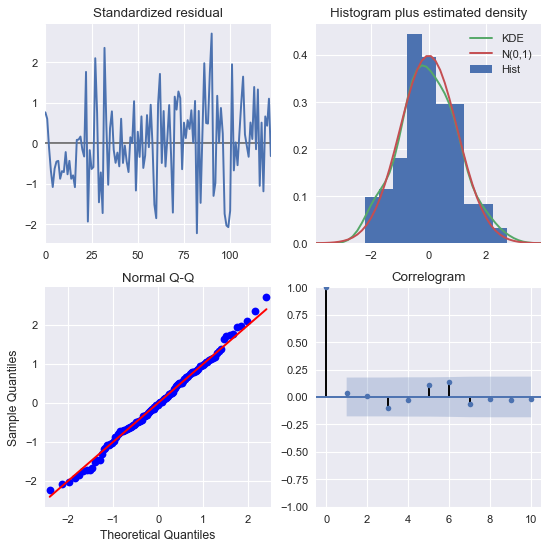

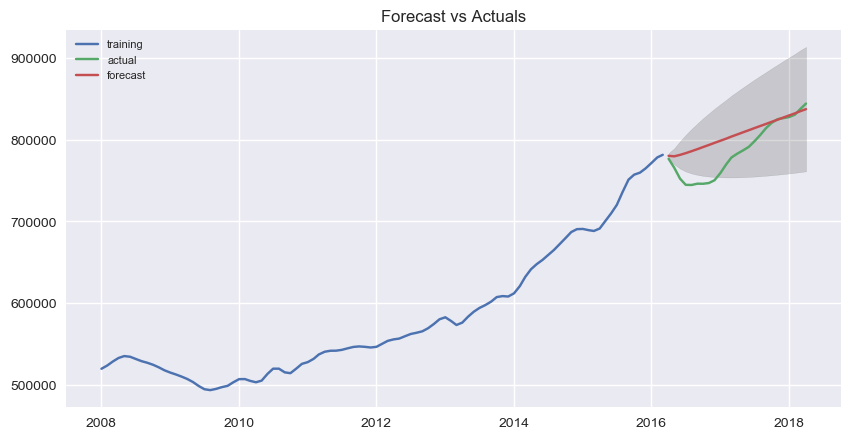

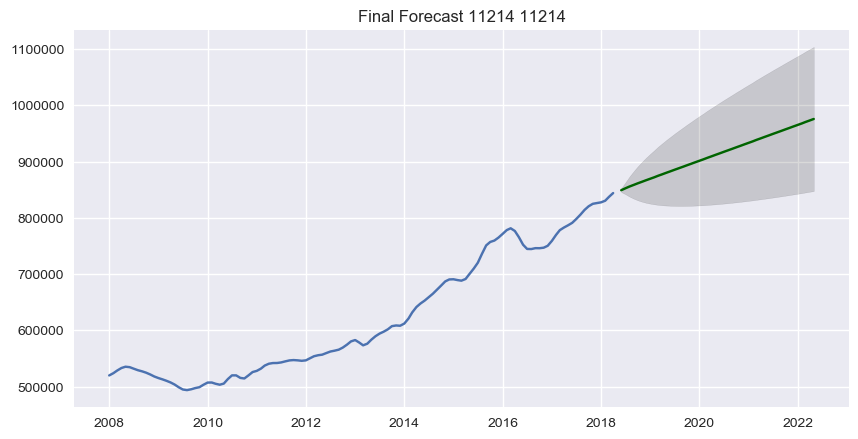

11214
Model Order:  (2, 1, 2)
Upside case 2022:  1103791.5421244893 ROI:  29.986521340276752
Base   case 2022:  975760.1135341156 ROI:  14.909072936697887
Low    case 2022:  847728.6849437419 ROI:  -0.16837546688097507
Zip:  11235
ADF Statistic Residual: -3.737959
p-value: 0.003610


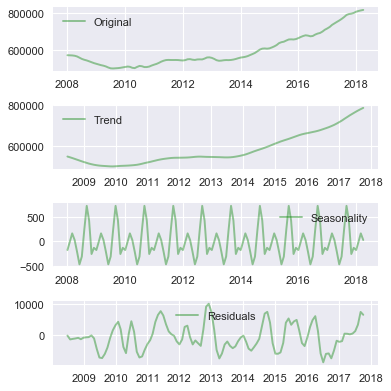

Fit ARIMA: order=(1, 1, 1); AIC=2242.669, BIC=2253.917, Fit time=0.285 seconds
Fit ARIMA: order=(0, 1, 0); AIC=2413.128, BIC=2418.753, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=2284.284, BIC=2292.720, Fit time=0.101 seconds
Fit ARIMA: order=(0, 1, 1); AIC=2297.864, BIC=2306.300, Fit time=0.131 seconds
Fit ARIMA: order=(2, 1, 1); AIC=2243.223, BIC=2257.284, Fit time=0.266 seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.871 seconds
11235
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  123
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1117.334
Method:                       css-mle   S.D. of innovations           2116.275
Date:                Mon, 02 Dec 2019   AIC                           2242.669
Time:                        22:26:21   

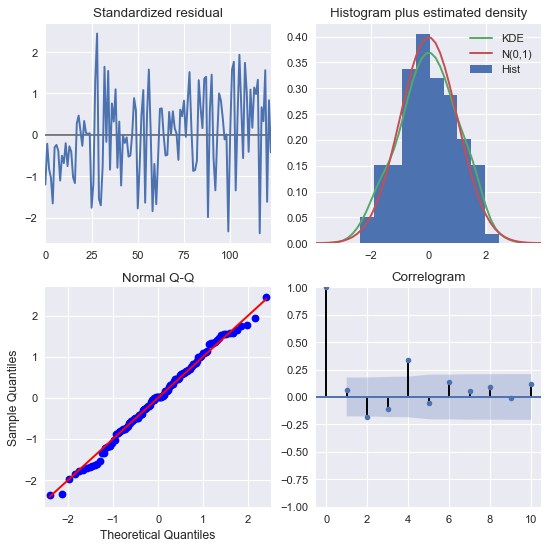

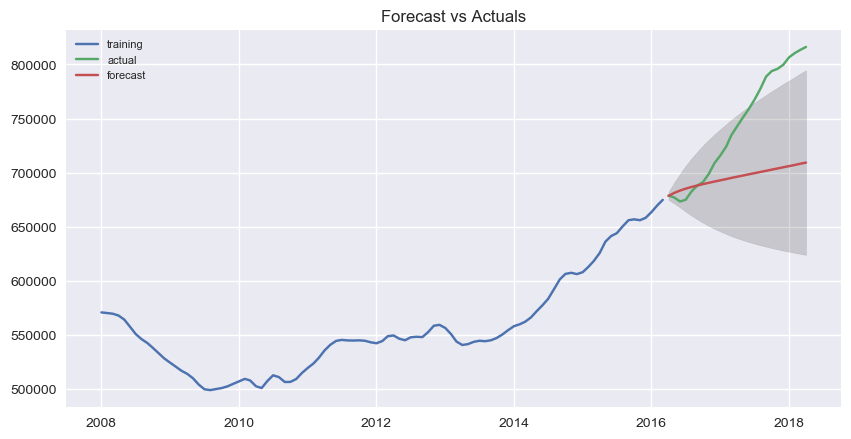

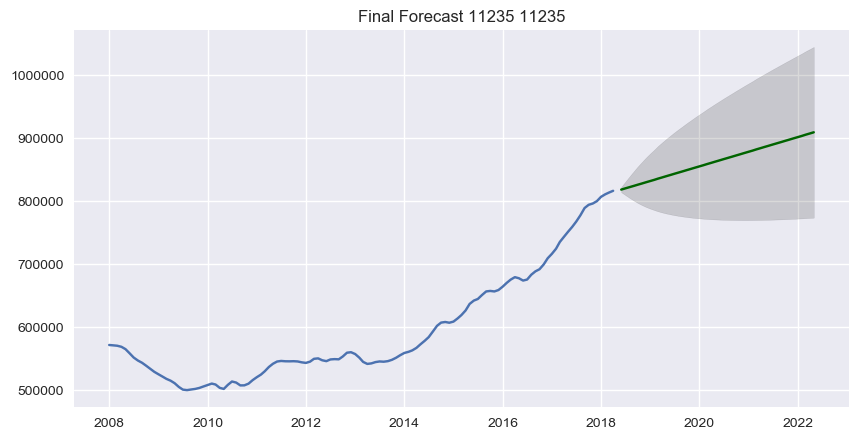

11235
Model Order:  (1, 1, 1)
Upside case 2022:  1045083.9304138897 ROI:  27.742649435734414
Base   case 2022:  909282.2279666895 ROI:  11.143342180461309
Low    case 2022:  773480.5255194893 ROI:  -5.455965074811794
Zip:  11377
ADF Statistic Residual: -4.765448
p-value: 0.000063


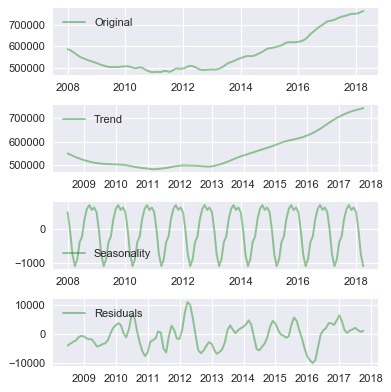

Fit ARIMA: order=(1, 2, 1); AIC=2173.950, BIC=2185.166, Fit time=0.286 seconds
Fit ARIMA: order=(0, 2, 0); AIC=2222.090, BIC=2227.698, Fit time=0.004 seconds
Fit ARIMA: order=(1, 2, 0); AIC=2211.316, BIC=2219.728, Fit time=0.084 seconds
Fit ARIMA: order=(0, 2, 1); AIC=2172.001, BIC=2180.413, Fit time=0.115 seconds
Fit ARIMA: order=(0, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.536 seconds
11377
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  122
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1083.000
Method:                       css-mle   S.D. of innovations           1728.738
Date:                Mon, 02 Dec 2019   AIC                           2172.001
Time:                        22:26:25   BIC                           2180.413
Sample:                             2   

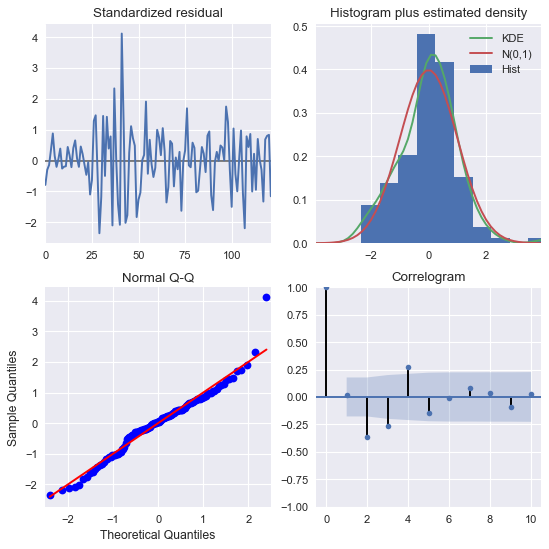

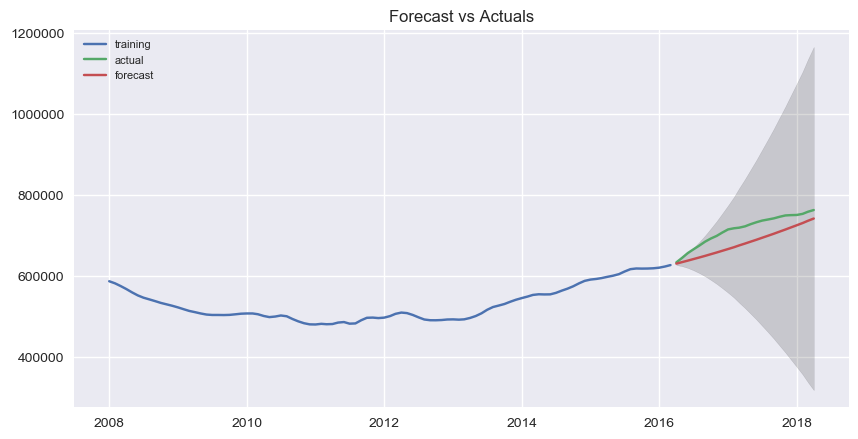

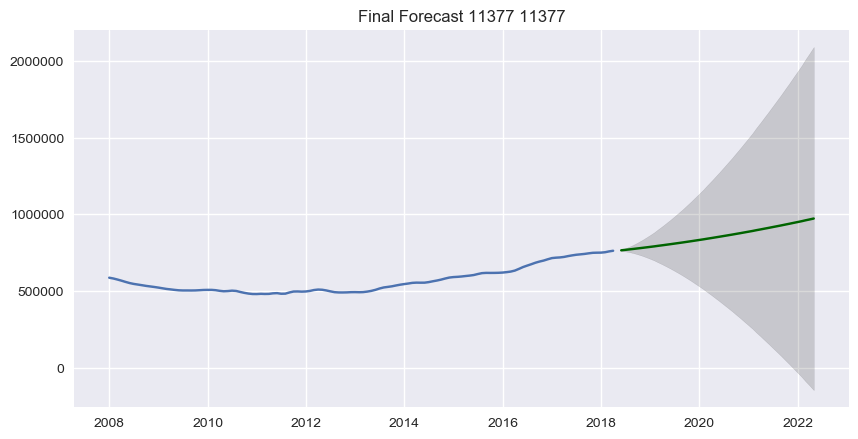

11377
Model Order:  (0, 2, 1)
Upside case 2022:  2093260.7160540102 ROI:  173.47575483822692
Base   case 2022:  972942.4771340055 ROI:  27.110864073336582
Low    case 2022:  -147375.76178599906 ROI:  -119.25402669155373


In [355]:
# compute residuals and create an ARMA model of the residuals.

from statsmodels.tsa.seasonal import seasonal_decompose

residuals_list = []
for z in zipcodes: 
    df_z = top5_post2008[top5_post2008.RegionName == z]
    ts = df_z.value
    decomposition = seasonal_decompose(ts)

    # Gather the trend, seasonality and noise of decomposed object
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    df_z['res'] = residual
    residuals_list.append(residual)
    
    # Plot gathered statistics
    plt.figure(figsize=(5,5))
    plt.subplot(411)
    plt.plot(ts, label='Original', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    result = adfuller(residual.dropna())
    print('Zip: ', z)
    print('ADF Statistic Residual: %f' % result[0])
    print('p-value: %f' % result[1])
    plt.show()
    

    model = pm.auto_arima(df_z.value.dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest (dickey fuller) to find optimal 'd'
                      max_p=10, max_q=10, # set maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   #  Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    print(z)
    print(model.summary())
    model.plot_diagnostics(figsize=(8, 8))
    plt.show()
    
    #============= PLOT TRAIN AND TEST =========
    #df_z.reset_index(inplace=True)
    train = df_z.value[:99] # 80 percent of data
    test = df_z.value[99:]  #20 percent of data
    
    test_index = top5_post2008.index[-25:]
    model2 = ARIMA(train, order=model.order)
    fitted = model2.fit(disp=-1)  
                   
    # Forecast
    fc, se, conf = fitted.forecast(25, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_index)
    lower_series = pd.Series(conf[:, 0], index=test_index)
    upper_series = pd.Series(conf[:, 1], index=test_index)

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    #print('Mean Error :', np.mean(fc_series - test))
    
    
    #==============PLOT FORECAST =========================
    #df_z.reset_index(inplace=True)
    n_periods = 48
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    #index_of_fc = np.arange(len(df_z.value), len(df_z.value)+n_periods)
    
    index_of_fc = pd.date_range('2018-05-01', periods=48, freq='M')
    # make series for plotting purpose
    fc_series = pd.Series(fc, index=(index_of_fc))
    lower_series = pd.Series(confint[:, 0], index=(index_of_fc))
    upper_series = pd.Series(confint[:, 1], index=(index_of_fc))

    # Plot
    plt.figure(figsize=(10,5), dpi=100)

    plt.plot(fc_series, color='darkgreen')
    plt.plot(df_z.value)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

    plt.title("Final Forecast " + str(z) + ' ' + str(df_z.RegionName[0]))
    plt.show()
    print(z)
    print('Model Order: ', model.order)
    print('Upside case 2022: ', upper_series[-1], 'ROI: ', (upper_series[-1]-fc_series[-48])/fc_series[-48]*100)
    print('Base   case 2022: ', fc_series[-1], 'ROI: ', (fc_series[-1]-fc_series[-48])/fc_series[-48]*100)
    print('Low    case 2022: ', lower_series[-1], 'ROI: ', (lower_series[-1]-fc_series[-48])/fc_series[-48]*100)

# Results/Business Recommendations

 - In Queens the top zip codes to invest in are Elmhurst and Jackson Heights. Woodside has a higher risk and may not be as suitable.
 - In Brooklyn, both zip codes had good performance and would be ideal to invest in.

# Future Work

 - Use a more current dataset to get a larger sample size of post 2008 data.
 - Include demographics into the initial criteria 